In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Configurações de plotagem
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

## [1] Leitura do Arquivo LHE

**Fazendo a leitura utilizando um dataframe do pandas.**

In [3]:
def lhe_to_dataframe(filename, label):
    """
    Lê um arquivo .lhe e converte para um DataFrame Pandas.
    Extrai apenas as informações das partículas dentro dos blocos <event>.
    """
    try:
        # LHE é um formato misto (XML + Texto tabular). 
        # O jeito mais seguro via Pandas é parsear o XML e processar o texto.
        tree = ET.parse(filename)
        root = tree.getroot()
    except Exception as e:
        print(f"Erro ao ler o arquivo {filename}: {e}")
        return pd.DataFrame()

    all_particles = []
    
    # Itera sobre cada evento no arquivo
    for event_id, event in enumerate(root.findall('event')):
        lines = event.text.strip().split('\n')
        
        # A primeira linha é o cabeçalho do evento (ignoramos aqui, pegamos só partículas)
        # As linhas subsequentes são as partículas
        for line in lines[1:]:
            parts = line.split()
            if len(parts) < 13: continue # Garante que a linha está completa
            
            # Estrutura padrão LHE:
            # ID Status Mother1 Mother2 Color1 Color2 Px Py Pz E Mass VTIM SPIN
            particle_data = {
                'event_id': event_id,
                'pdg_id': int(parts[0]),
                'status': int(parts[1]),
                'mother1': int(parts[2]),
                'mother2': int(parts[3]),
                'px': float(parts[6]),
                'py': float(parts[7]),
                'pz': float(parts[8]),
                'e': float(parts[9]),
                'mass': float(parts[10]),
                'label': label  # Identifica se é Sinal ou Fundo
            }
            all_particles.append(particle_data)

    # Cria o DataFrame
    df = pd.DataFrame(all_particles)
    return df

# --- DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI ---
# Exemplo: 'caminho/para/sinal.lhe' e 'caminho/para/fundo.lhe'
file_signal = './data/signal.lhe' 
file_background = './data/background.lhe'

print("Lendo arquivos... (isso pode demorar dependendo do tamanho)")

# Leitura (Se não tiver o arquivo de fundo, comente a linha correspondente)
df_signal = lhe_to_dataframe(file_signal, 'Sinal')
df_bkg = lhe_to_dataframe(file_background, 'Fundo')

# Concatena os dois para facilitar análises conjuntas, mas mantém o label
if not df_bkg.empty:
    df_total = pd.concat([df_signal, df_bkg], ignore_index=True)
else:
    df_total = df_signal.copy()

print("Leitura concluída!")
df_total.head()

Lendo arquivos... (isso pode demorar dependendo do tamanho)
Leitura concluída!


,event_id,pdg_id,status,mother1,mother2,px,py,pz,e,mass,label
0,0,21,-1,0,0,0.000000,0.000000,103.849954,103.849954,0.000000,Sinal
1,0,21,-1,0,0,-0.000000,-0.000000,-37.615172,37.615172,0.000000,Sinal
2,0,25,2,1,2,0.000000,0.000000,66.234782,141.465126,125.001342,Sinal
3,0,22,1,3,3,53.205388,-32.691024,36.072332,72.116083,0.000000,Sinal
4,0,22,1,3,3,-53.205388,32.691024,30.162450,69.349043,0.000000,Sinal


## [2a] Investigação Preliminar do Arquivo

### Objetivo:
**Exibir o número total de eventos da amostra com o método escolhido.**

In [4]:
# Conta eventos únicos baseados no 'event_id' para cada label
n_events_signal = df_total[df_total['label'] == 'Sinal']['event_id'].nunique()
n_events_bkg = df_total[df_total['label'] == 'Fundo']['event_id'].nunique()

print(f"=== Contagem de Eventos ===")
print(f"Número total de eventos (Sinal): {n_events_signal}")
if n_events_bkg > 0:
    print(f"Número total de eventos (Fundo): {n_events_bkg}")
print(f"Total combinado: {n_events_signal + n_events_bkg}")

=== Contagem de Eventos ===
Número total de eventos (Sinal): 10000
Número total de eventos (Fundo): 10000
Total combinado: 20000


## [2b] Investigação Preliminar dos Eventos

### Objetivo 1:
**Construir uma tabela das partículas presentes nos eventos, classificadas pelos seus status:**

In [5]:
def analyze_particles(df, label_name):
    print(f"\n--- Análise de Partículas: {label_name} ---")
    subset = df[df['label'] == label_name]
    
    # Status padrão LHE: -1 (Entrada), 1 (Saída estável), 2 (Intermediário/Ressonância)
    status_map = {-1: 'Inicial', 1: 'Final (Detectável)', 2: 'Intermediária'}
    
    # Agrupa por Status e PDG ID
    summary = subset.groupby(['status', 'pdg_id']).size().reset_index(name='contagem')
    summary['desc_status'] = summary['status'].map(status_map)
    
    # Exibe tabela formatada
    print(summary[['status', 'desc_status', 'pdg_id', 'contagem']].to_string(index=False))

# Executa para o Sinal
analyze_particles(df_total, 'Sinal')

# Executa para o Fundo (se existir)
if n_events_bkg > 0:
    analyze_particles(df_total, 'Fundo')


--- Análise de Partículas: Sinal ---
 status        desc_status  pdg_id  contagem
     -1            Inicial      21     20000
      1 Final (Detectável)      22     20000
      2      Intermediária      25      9796

--- Análise de Partículas: Fundo ---
 status        desc_status  pdg_id  contagem
     -1            Inicial      -4      1682
     -1            Inicial      -3       154
     -1            Inicial      -2      7694
     -1            Inicial      -1       470
     -1            Inicial       1       470
     -1            Inicial       2      7694
     -1            Inicial       3       154
     -1            Inicial       4      1682
      1 Final (Detectável)      22     20000


## [2b] Investigação Preliminar dos Eventos

### Objetivo 2:
**Com base nas partículas e seus status, identificar:**

**- Qual é o processo de sinal?**

$gg \to H \to \gamma\gamma$

**- Qual é o processo de fundo (background)?**

$ q\bar{q} \to \gamma\gamma $

Podendo ser:

$ u\bar{u} \to \gamma\gamma $ (76.94%)

$ c\bar{c} \to \gamma\gamma $ (16.82%)

$ d\bar{d} \to \gamma\gamma $ (4.70%)

$ s\bar{s} \to \gamma\gamma $ (1.54%)

## [3] Exploração do Conteúdo

### Objetivo 1:
**Construir histogramas para as partículas de estado final (exceto neutrinos), com as variáveis cinemáticas:**

### Objetivo 2:
**Imprimir o número total de eventos representados em cada histograma.**

### Pergunta:
**Os histogramas representam todos os eventos do arquivo LHE?** 
**Se não, explique o porquê (por exemplo: presença ou ausência de certas partículas nos eventos).**

Sim, pois não foi feito nenhum corte e não havia nenhum evento contendo apenas neutrinos.

Cálculos cinemáticos realizados e neutrinos removidos dos dados de plotagem.


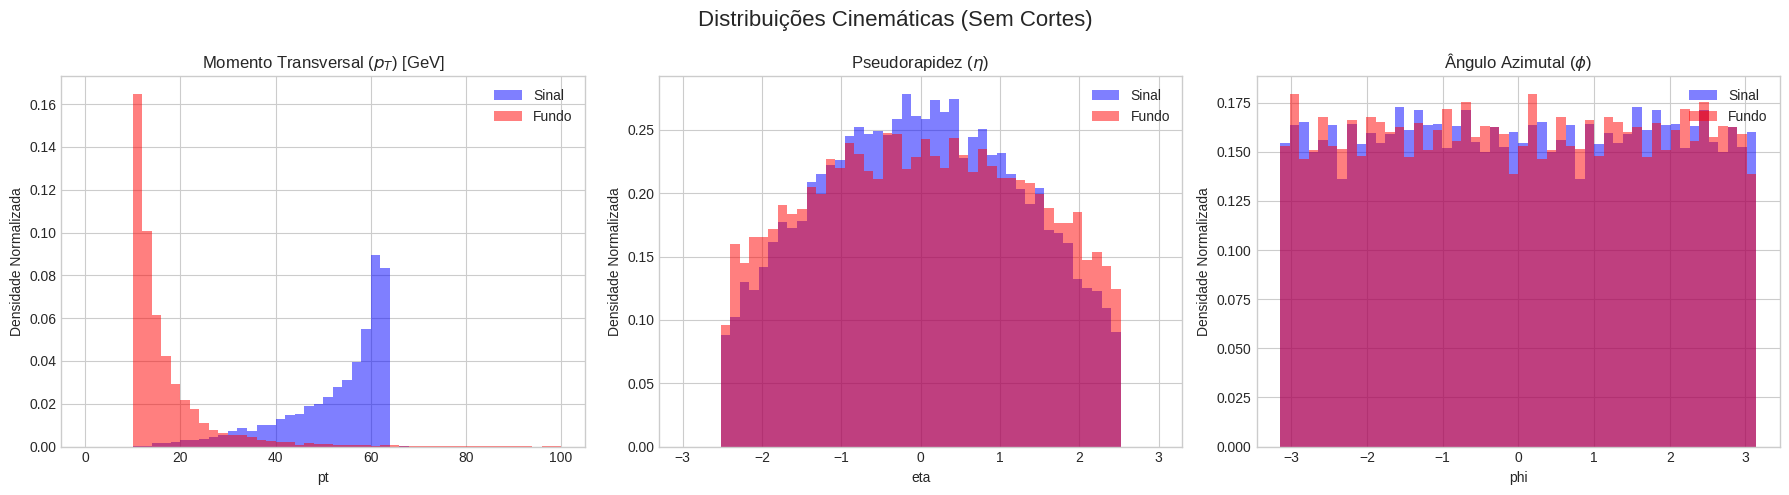

--- Estatísticas do Gráfico (Sem Cortes) ---
[Sinal] Entradas (partículas) plotadas: 20000 | Eventos originais: 10000
[Fundo] Entradas (partículas) plotadas: 20000 | Eventos originais: 10000


In [6]:
# Funções para cálculo cinemático
def calculate_kinematics(df):
    # pT = sqrt(px^2 + py^2)
    df['pt'] = np.sqrt(df['px']**2 + df['py']**2)
    
    # phi = arctan2(py, px)
    df['phi'] = np.arctan2(df['py'], df['px'])
    
    # theta e pseudorapidez (eta)
    # p_total = sqrt(pt^2 + pz^2)
    p_total = np.sqrt(df['pt']**2 + df['pz']**2)
    
    # Evitar divisão por zero e logs inválidos
    # eta = 0.5 * ln((p + pz) / (p - pz))
    with np.errstate(divide='ignore', invalid='ignore'):
        df['eta'] = 0.5 * np.log((p_total + df['pz']) / (p_total - df['pz']))
        
    return df

# Aplica os cálculos
df_total = calculate_kinematics(df_total)

# Filtragem para Plotagem (Objetivo 1):
# 1. Apenas estado final (Status = 1)
# 2. Excluir Neutrinos (PDG IDs: 12, 14, 16 e antipartículas -12, -14, -16)
neutrinos = [12, 14, 16, -12, -14, -16]

df_plot = df_total[
    (df_total['status'] == 1) & 
    (~df_total['pdg_id'].isin(neutrinos))
].copy()

print("Cálculos cinemáticos realizados e neutrinos removidos dos dados de plotagem.")

def plot_histograms(df, title_suffix=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    variables = [
        ('pt', 'Momento Transversal ($p_T$) [GeV]', 50, (0, 100)),
        ('eta', 'Pseudorapidez ($\eta$)', 50, (-3, 3)),
        ('phi', 'Ângulo Azimutal ($\phi$)', 50, (-np.pi, np.pi))
    ]
    
    labels = df['label'].unique()
    colors = {'Sinal': 'blue', 'Fundo': 'red'}
    
    for i, (var, title, bins, rnge) in enumerate(variables):
        ax = axes[i]
        
        # Loop para plotar Sinal e Fundo sobrepostos
        for lab in labels:
            data = df[df['label'] == lab][var]
            # remove NaNs gerados por eta infinito se houver
            data = data.dropna()
            
            ax.hist(data, bins=bins, range=rnge, alpha=0.5, label=lab, 
                    color=colors.get(lab, 'gray'), density=True) # density=True para comparar formas
            
        ax.set_title(title)
        ax.set_xlabel(var)
        ax.set_ylabel("Densidade Normalizada")
        ax.legend()
        
    plt.suptitle(f"Distribuições Cinemáticas {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Objetivo 2: Imprimir número de eventos representados
    print(f"--- Estatísticas do Gráfico {title_suffix} ---")
    for lab in labels:
        n_entries = len(df[df['label'] == lab])
        n_ev = df[df['label'] == lab]['event_id'].nunique()
        print(f"[{lab}] Entradas (partículas) plotadas: {n_entries} | Eventos originais: {n_ev}")

# Plotagem Inicial
plot_histograms(df_plot, "(Sem Cortes)")

## [4] Filtros e Cortes Cinemáticos

### Objetivo 1:
**Analisar se cortes cinemáticos simples ajudam a remover o fundo.**

Sim, ajudam.

### Objetivo 2:
**Se for útil, aplique o corte e reconstrua os histogramas com a nova seleção.**

Aplicarei o corte $p_T>\text{ 40.0 GeV}$ e $|\eta| < 2.5$ (valor típico do CMS).

Aplicando cortes: pT > 40.0 GeV e |eta| < 2.5


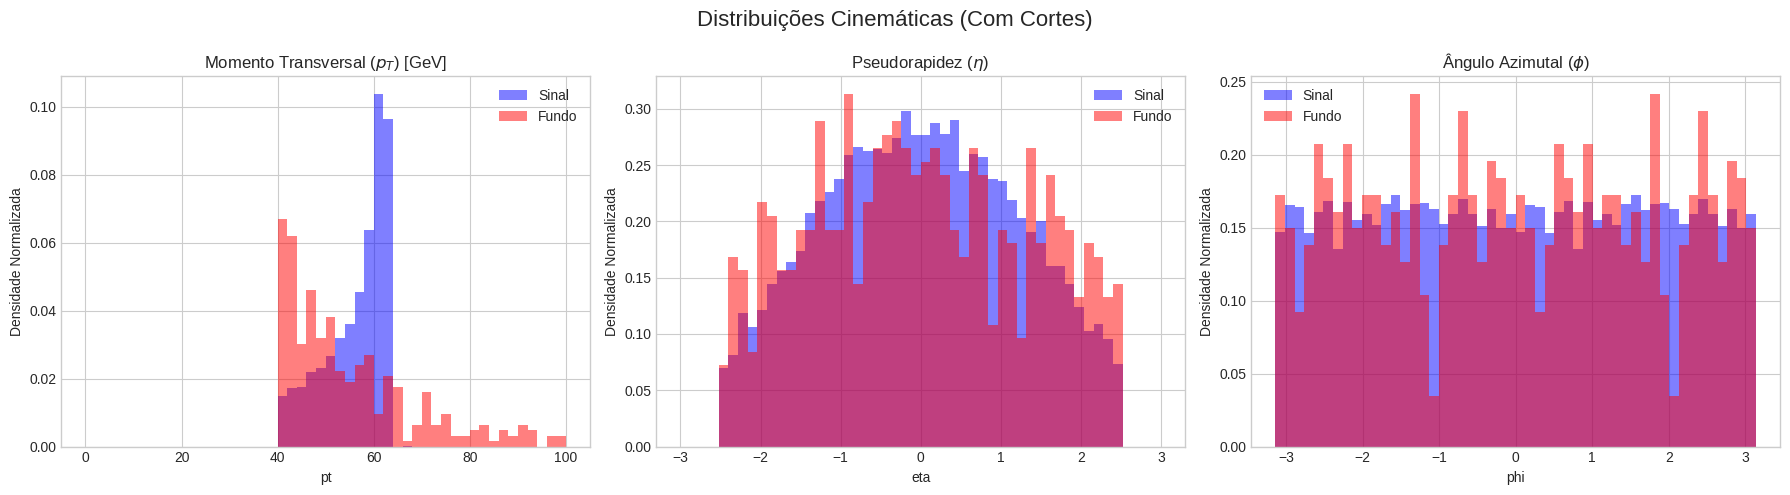

--- Estatísticas do Gráfico (Com Cortes) ---
[Sinal] Entradas (partículas) plotadas: 17252 | Eventos originais: 8626
[Fundo] Entradas (partículas) plotadas: 692 | Eventos originais: 346

--- Eficiência do Corte (Partículas Sobreviventes) ---
[Sinal] 20000 -> 17252 (86.26%)
[Fundo] 20000 -> 692 (3.46%)


In [7]:
# --- Configuração dos Cortes ---
# Exemplo: Selecionar apenas partículas com alto pT e centrais (eta baixo)
CUT_PT = 40.0  # GeV
CUT_ETA = 2.5  # Valor absoluto

print(f"Aplicando cortes: pT > {CUT_PT} GeV e |eta| < {CUT_ETA}")

# Aplica o filtro no DataFrame já preparado para plot (df_plot)
df_cut = df_plot[
    (df_plot['pt'] > CUT_PT) & 
    (df_plot['eta'].abs() < CUT_ETA)
].copy()

# Reconstrói os histogramas
plot_histograms(df_cut, "(Com Cortes)")

# Análise de eficiência
print("\n--- Eficiência do Corte (Partículas Sobreviventes) ---")
for lab in df_plot['label'].unique():
    original = len(df_plot[df_plot['label'] == lab])
    final = len(df_cut[df_cut['label'] == lab])
    if original > 0:
        eff = (final / original) * 100
        print(f"[{lab}] {original} -> {final} ({eff:.2f}%)")

In [8]:
# --- [5] CONSERVAÇÃO DE ENERGIA ---

# 1. Filtrar apenas partículas finais (status 1) e remover neutrinos
neutrinos = [12, 14, 16, -12, -14, -16]
df_final_state = df_total[
    (df_total['status'] == 1) & 
    (~df_total['pdg_id'].isin(neutrinos))
].copy()

# 2. Agrupar por evento e somar os quadrivetores (E, px, py, pz)
# Isso soma a energia e momento de TODAS as partículas finais do evento
event_sums = df_final_state.groupby(['label', 'event_id'])[['e', 'px', 'py', 'pz']].sum()

# 3. Calcular s = E^2 - (px^2 + py^2 + pz^2)
event_sums['p_mod_sq'] = event_sums['px']**2 + event_sums['py']**2 + event_sums['pz']**2
event_sums['s'] = event_sums['e']**2 - event_sums['p_mod_sq']
event_sums['sqrt_s'] = np.sqrt(event_sums['s']) # Energia no centro de massa

print("=== Verificação da Variável de Mandelstam 's' (GeV^2) ===")

# 4. Imprimir eventos específicos (1, 1001, 2001...)
# Como o índice é MultiIndex (label, event_id), vamos iterar de forma cuidadosa
labels = event_sums.index.get_level_values('label').unique()

for lab in labels:
    print(f"\n--- Amostra: {lab} ---")
    subset = event_sums.xs(lab, level='label')
    
    # Itera de 0 a 9 (i), pegando o evento 1 + 1000*i -> Ajuste de índice se começar em 0 ou 1
    # O enunciado pede "1 + 1000*i". Se seus IDs começam em 0, seria 0, 1000, 2000...
    # Vamos assumir índice posicional para garantir
    
    indices_to_print = [0 + 1000*i for i in range(10)]
    
    for idx in indices_to_print:
        if idx < len(subset):
            # Acessa pelo índice posicional (iloc)
            val_s = subset.iloc[idx]['s']
            val_sqrt_s = subset.iloc[idx]['sqrt_s']
            # Recupera o ID real do evento
            real_event_id = subset.index[idx]
            
            print(f"Evento {real_event_id:4d} | s = {val_s:.4e} GeV² | sqrt(s) = {val_sqrt_s:.4f} GeV")

=== Verificação da Variável de Mandelstam 's' (GeV^2) ===

--- Amostra: Fundo ---
Evento    0 | s = 6.9090e+02 GeV² | sqrt(s) = 26.2849 GeV
Evento 1000 | s = 1.8067e+03 GeV² | sqrt(s) = 42.5057 GeV
Evento 2000 | s = 2.4775e+03 GeV² | sqrt(s) = 49.7740 GeV
Evento 3000 | s = 1.0987e+03 GeV² | sqrt(s) = 33.1474 GeV
Evento 4000 | s = 8.2478e+03 GeV² | sqrt(s) = 90.8175 GeV
Evento 5000 | s = 8.6092e+02 GeV² | sqrt(s) = 29.3414 GeV
Evento 6000 | s = 6.1529e+02 GeV² | sqrt(s) = 24.8051 GeV
Evento 7000 | s = 1.1020e+03 GeV² | sqrt(s) = 33.1961 GeV
Evento 8000 | s = 5.6711e+02 GeV² | sqrt(s) = 23.8141 GeV
Evento 9000 | s = 1.2231e+03 GeV² | sqrt(s) = 34.9724 GeV

--- Amostra: Sinal ---
Evento    0 | s = 1.5625e+04 GeV² | sqrt(s) = 125.0013 GeV
Evento 1000 | s = 1.5616e+04 GeV² | sqrt(s) = 124.9621 GeV
Evento 2000 | s = 1.5624e+04 GeV² | sqrt(s) = 124.9945 GeV
Evento 3000 | s = 1.5628e+04 GeV² | sqrt(s) = 125.0136 GeV
Evento 4000 | s = 1.5626e+04 GeV² | sqrt(s) = 125.0034 GeV
Evento 5000 | s = 1


=== Análise de Massa Invariante ===



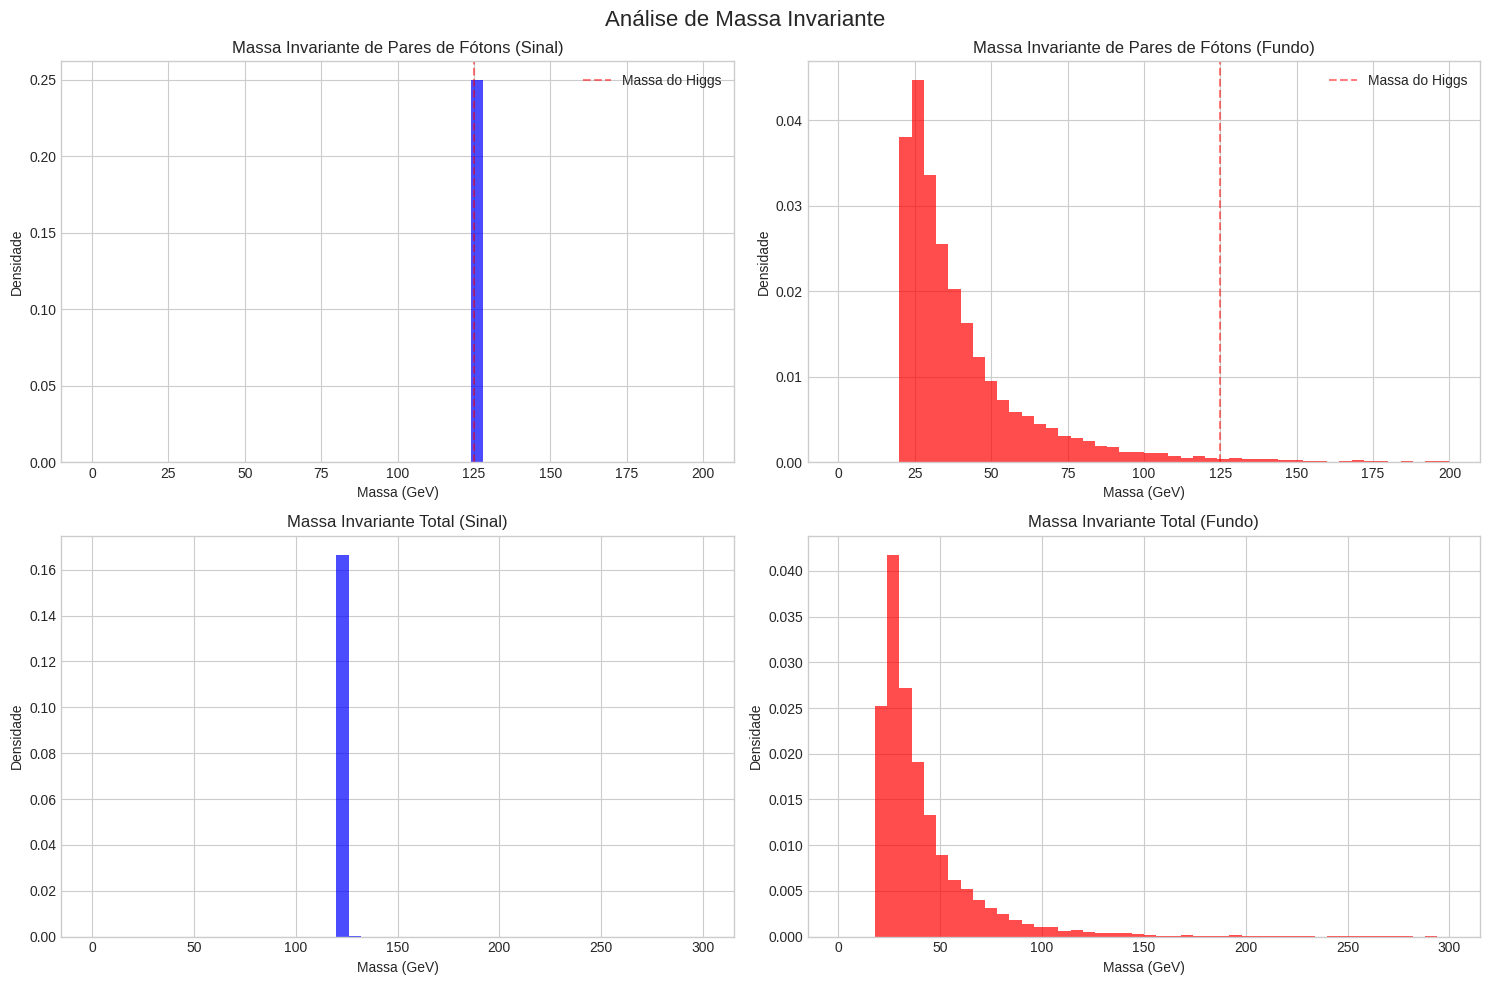


=== Histogramas 2D: Massa Invariante vs η ===


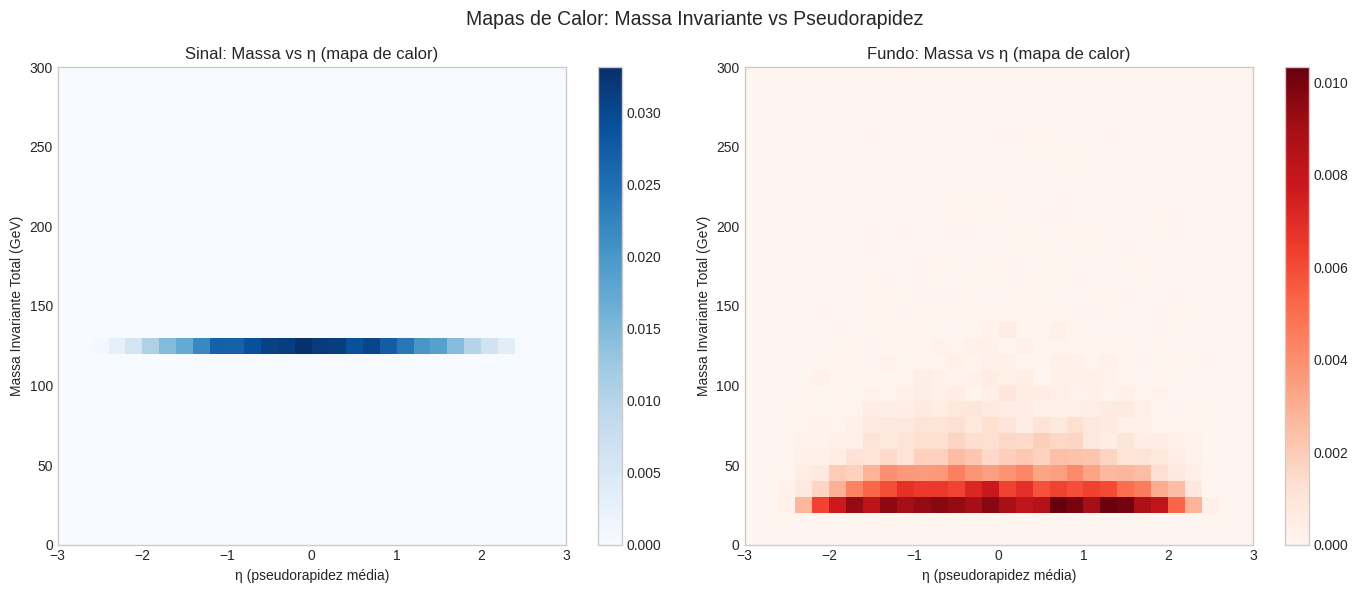

In [15]:
# --- [6] RECONSTRUÇÃO DE VARIÁVEIS ---
# Construir histogramas de Massa Invariante

def calculate_invariant_mass(particle1, particle2):
    """
    Calcula a massa invariante entre duas partículas.
    M^2 = (E1 + E2)^2 - (px1+px2)^2 - (py1+py2)^2 - (pz1+pz2)^2
    """
    E = particle1['e'] + particle2['e']
    px = particle1['px'] + particle2['px']
    py = particle1['py'] + particle2['py']
    pz = particle1['pz'] + particle2['pz']
    
    M2 = E**2 - px**2 - py**2 - pz**2
    
    # Garantir que M2 não seja negativo devido a erros numéricos
    if M2 < 0:
        M2 = 0
    
    return np.sqrt(M2)

def calculate_total_invariant_mass(particles):
    """
    Calcula a massa invariante total de um conjunto de partículas.
    """
    E_total = particles['e'].sum()
    px_total = particles['px'].sum()
    py_total = particles['py'].sum()
    pz_total = particles['pz'].sum()
    
    M2 = E_total**2 - px_total**2 - py_total**2 - pz_total**2
    
    if M2 < 0:
        M2 = 0
    
    return np.sqrt(M2)

# Filtrar partículas para análise de massa invariante
df_inv_mass = df_total[
    (df_total['status'] == 1) & 
    (~df_total['pdg_id'].isin(neutrinos))
].copy()

# Separar sinal e fundo
df_signal_mass = df_inv_mass[df_inv_mass['label'] == 'Sinal']
df_bkg_mass = df_inv_mass[df_inv_mass['label'] == 'Fundo']

# 1. Histogramas de massa invariante para pares de partículas
print("\n=== Análise de Massa Invariante ===\n")

# Para sinal: pares de fótons (pdg_id = 22)
signal_photons_events = {}
for event_id in df_signal_mass['event_id'].unique():
    event_photons = df_signal_mass[
        (df_signal_mass['event_id'] == event_id) & 
        (df_signal_mass['pdg_id'] == 22)
    ]
    if len(event_photons) >= 2:
        # Calcular massa invariante para todos os pares de fótons
        photon_pairs = []
        for i in range(len(event_photons)):
            for j in range(i+1, len(event_photons)):
                photon1 = event_photons.iloc[i]
                photon2 = event_photons.iloc[j]
                mass = calculate_invariant_mass(photon1, photon2)
                photon_pairs.append(mass)
        
        if photon_pairs:
            signal_photons_events[event_id] = photon_pairs

# Para fundo: pares de fótons (pdg_id = 22)
bkg_photons_events = {}
for event_id in df_bkg_mass['event_id'].unique():
    event_photons = df_bkg_mass[
        (df_bkg_mass['event_id'] == event_id) & 
        (df_bkg_mass['pdg_id'] == 22)
    ]
    if len(event_photons) >= 2:
        photon_pairs = []
        for i in range(len(event_photons)):
            for j in range(i+1, len(event_photons)):
                photon1 = event_photons.iloc[i]
                photon2 = event_photons.iloc[j]
                mass = calculate_invariant_mass(photon1, photon2)
                photon_pairs.append(mass)
        
        if photon_pairs:
            bkg_photons_events[event_id] = photon_pairs

# Preparar dados para histogramas
signal_photon_masses = []
for masses in signal_photons_events.values():
    signal_photon_masses.extend(masses)

bkg_photon_masses = []
for masses in bkg_photons_events.values():
    bkg_photon_masses.extend(masses)

# 2. Massa invariante total de todas as partículas estáveis
signal_total_masses = []
for event_id in df_signal_mass['event_id'].unique():
    event_particles = df_signal_mass[df_signal_mass['event_id'] == event_id]
    if len(event_particles) > 0:
        total_mass = calculate_total_invariant_mass(event_particles)
        signal_total_masses.append(total_mass)

bkg_total_masses = []
for event_id in df_bkg_mass['event_id'].unique():
    event_particles = df_bkg_mass[df_bkg_mass['event_id'] == event_id]
    if len(event_particles) > 0:
        total_mass = calculate_total_invariant_mass(event_particles)
        bkg_total_masses.append(total_mass)

# Criar histogramas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1a. Massa invariante de pares de fótons (Sinal)
ax1 = axes[0, 0]
if signal_photon_masses:
    ax1.hist(signal_photon_masses, bins=50, range=(0, 200), 
             alpha=0.7, color='blue', density=True)
    ax1.set_title('Massa Invariante de Pares de Fótons (Sinal)')
    ax1.set_xlabel('Massa (GeV)')
    ax1.set_ylabel('Densidade')
    ax1.axvline(x=125, color='red', linestyle='--', alpha=0.5, label='Massa do Higgs')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax1.transAxes)

# 1b. Massa invariante de pares de fótons (Fundo)
ax2 = axes[0, 1]
if bkg_photon_masses:
    ax2.hist(bkg_photon_masses, bins=50, range=(0, 200), 
             alpha=0.7, color='red', density=True)
    ax2.set_title('Massa Invariante de Pares de Fótons (Fundo)')
    ax2.set_xlabel('Massa (GeV)')
    ax2.set_ylabel('Densidade')
    ax2.axvline(x=125, color='red', linestyle='--', alpha=0.5, label='Massa do Higgs')
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax2.transAxes)

# 2a. Massa invariante total (Sinal)
ax3 = axes[1, 0]
if signal_total_masses:
    ax3.hist(signal_total_masses, bins=50, range=(0, 300), 
             alpha=0.7, color='blue', density=True)
    ax3.set_title('Massa Invariante Total (Sinal)')
    ax3.set_xlabel('Massa (GeV)')
    ax3.set_ylabel('Densidade')
else:
    ax3.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax3.transAxes)

# 2b. Massa invariante total (Fundo)
ax4 = axes[1, 1]
if bkg_total_masses:
    ax4.hist(bkg_total_masses, bins=50, range=(0, 300), 
             alpha=0.7, color='red', density=True)
    ax4.set_title('Massa Invariante Total (Fundo)')
    ax4.set_xlabel('Massa (GeV)')
    ax4.set_ylabel('Densidade')
else:
    ax4.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax4.transAxes)

plt.suptitle('Análise de Massa Invariante', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Histogramas 2D (mapa de calor) de massa invariante versus eta
print("\n=== Histogramas 2D: Massa Invariante vs η ===")

# Para sinal: criar mapa de calor
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Preparar dados para histograma 2D do sinal
signal_eta_mass_data = []
for event_id in df_signal_mass['event_id'].unique():
    event_particles = df_signal_mass[df_signal_mass['event_id'] == event_id]
    if len(event_particles) >= 2:
        # Calcular eta médio e massa invariante total
        eta_avg = event_particles['eta'].mean()
        total_mass = calculate_total_invariant_mass(event_particles)
        signal_eta_mass_data.append([eta_avg, total_mass])

signal_eta_mass_data = np.array(signal_eta_mass_data)

ax1 = axes[0]
if len(signal_eta_mass_data) > 0:
    h1 = ax1.hist2d(signal_eta_mass_data[:, 0], signal_eta_mass_data[:, 1], 
                    bins=(30, 30), range=[[-3, 3], [0, 300]], 
                    cmap='Blues', density=True)
    ax1.set_title('Sinal: Massa vs η (mapa de calor)')
    ax1.set_xlabel('η (pseudorapidez média)')
    ax1.set_ylabel('Massa Invariante Total (GeV)')
    plt.colorbar(h1[3], ax=ax1)
else:
    ax1.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax1.transAxes)

# Preparar dados para histograma 2D do fundo
bkg_eta_mass_data = []
for event_id in df_bkg_mass['event_id'].unique():
    event_particles = df_bkg_mass[df_bkg_mass['event_id'] == event_id]
    if len(event_particles) >= 2:
        eta_avg = event_particles['eta'].mean()
        total_mass = calculate_total_invariant_mass(event_particles)
        bkg_eta_mass_data.append([eta_avg, total_mass])

bkg_eta_mass_data = np.array(bkg_eta_mass_data)

ax2 = axes[1]
if len(bkg_eta_mass_data) > 0:
    h2 = ax2.hist2d(bkg_eta_mass_data[:, 0], bkg_eta_mass_data[:, 1], 
                    bins=(30, 30), range=[[-3, 3], [0, 300]], 
                    cmap='Reds', density=True)
    ax2.set_title('Fundo: Massa vs η (mapa de calor)')
    ax2.set_xlabel('η (pseudorapidez média)')
    ax2.set_ylabel('Massa Invariante Total (GeV)')
    plt.colorbar(h2[3], ax=ax2)
else:
    ax2.text(0.5, 0.5, 'Sem dados suficientes', 
             ha='center', va='center', transform=ax2.transAxes)

plt.suptitle('Mapas de Calor: Massa Invariante vs Pseudorapidez', fontsize=14)
plt.tight_layout()
plt.show()


=== Normalização por Seção de Choque e Luminosidade ===

Luminosidade integrada: 10000 pb⁻¹
Seção de choque (Sinal): 0.01 pb
Seção de choque (Fundo): 100.0 pb

Número esperado de eventos (Sinal): 100.0
Número esperado de eventos (Fundo): 1000000.0

Número atual de eventos (Sinal): 10000
Número atual de eventos (Fundo): 10000

Fator de normalização (Sinal): 0.010000
Fator de normalização (Fundo): 100.000000


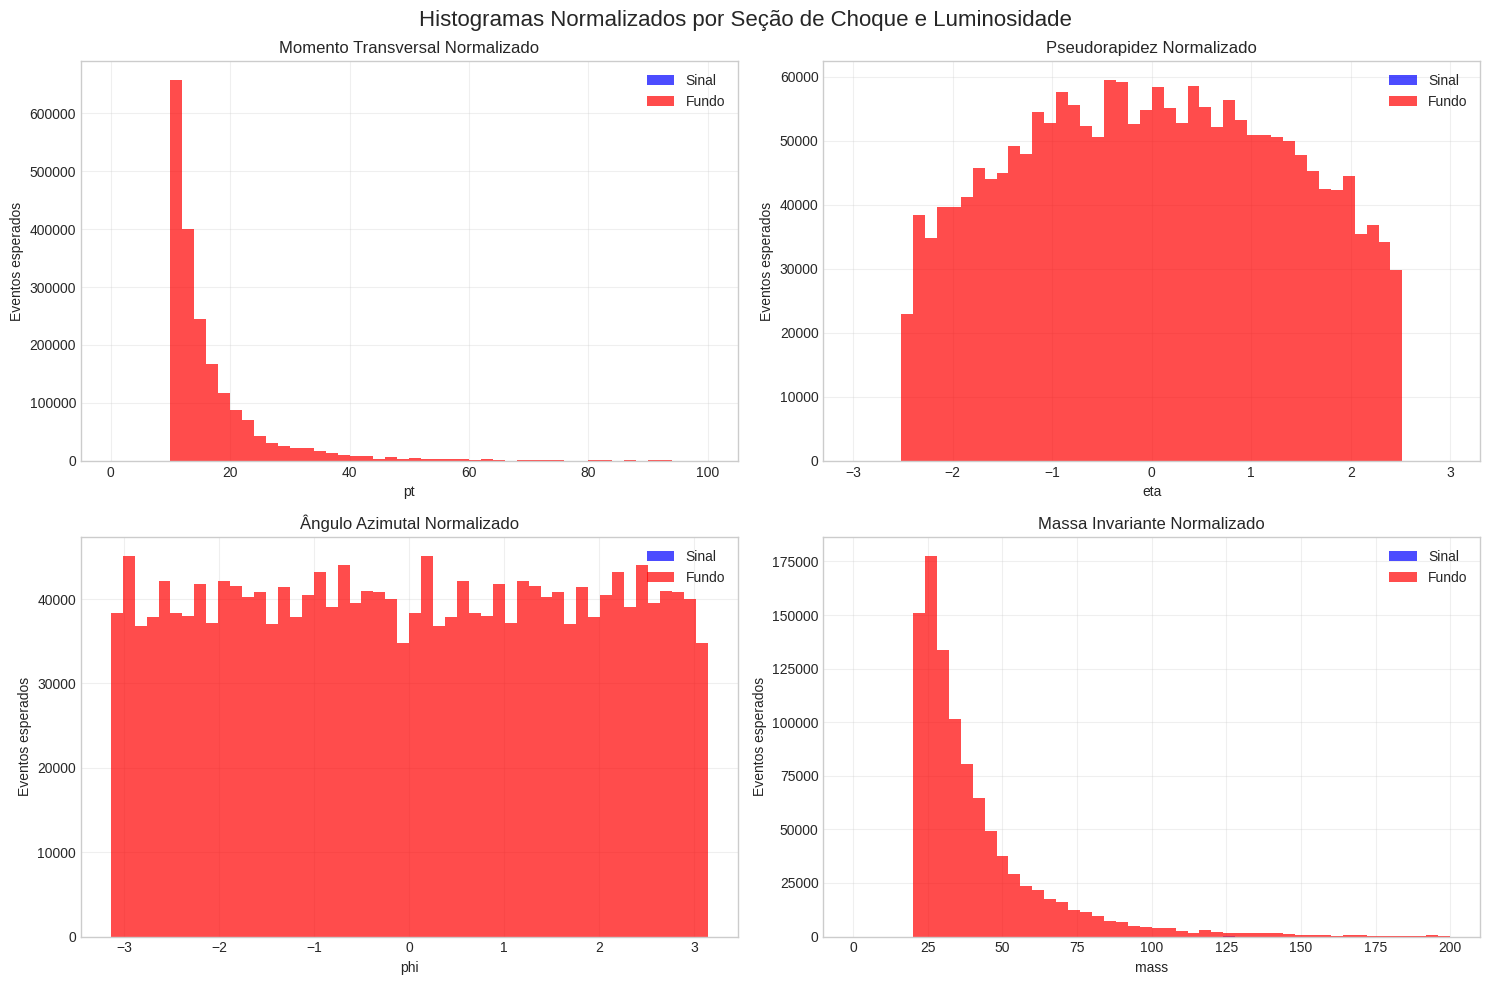


=== Histogramas Empilhados de Massa Invariante ===


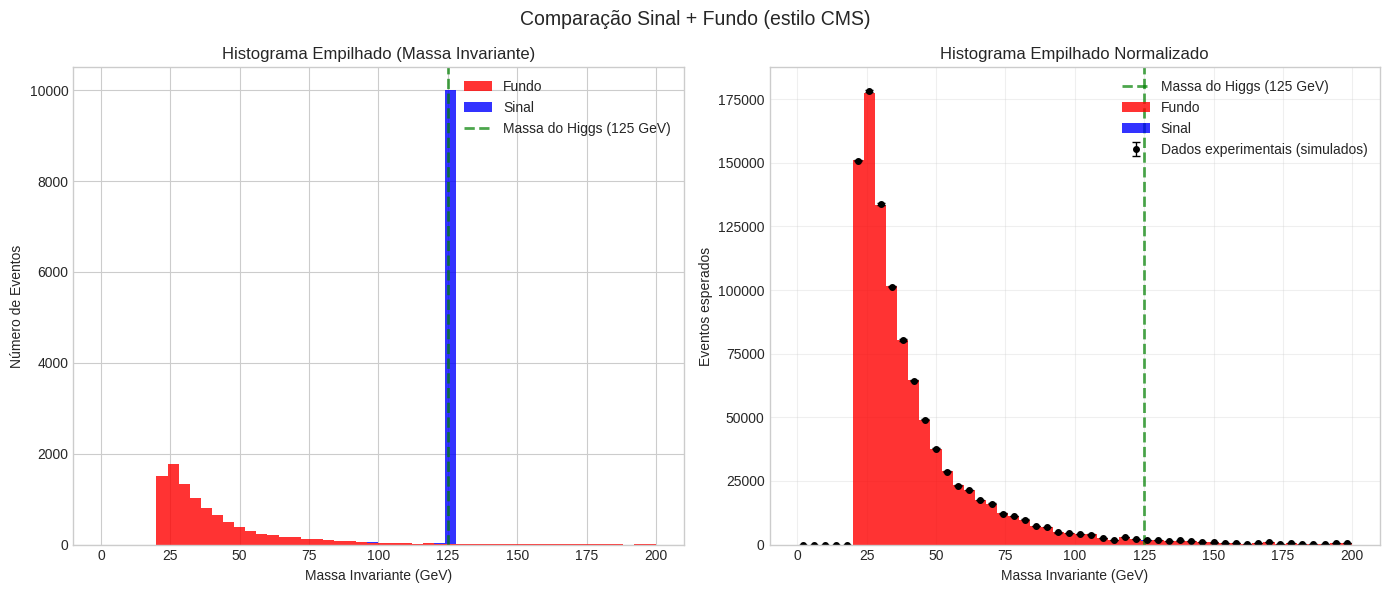


=== Razão Sinal/Fundo vs Massa Invariante ===


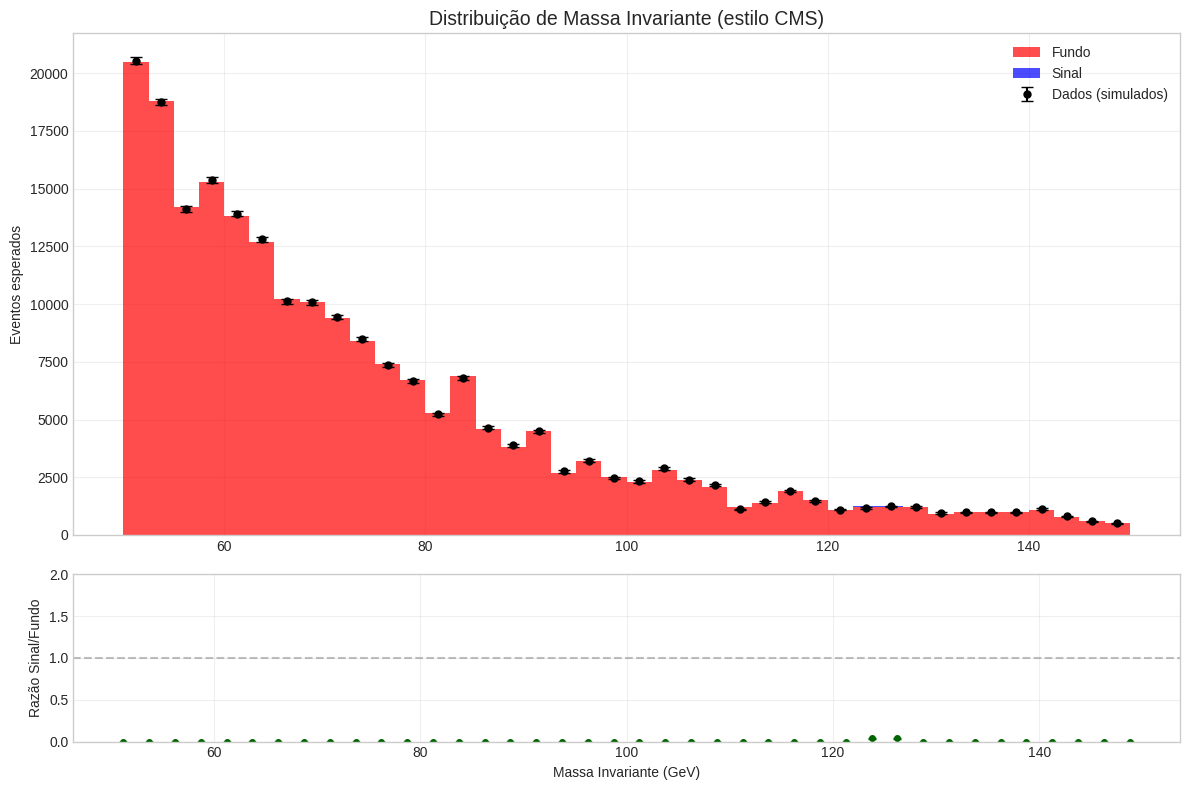

In [19]:
# --- [7] GRÁFICOS E VISUALIZAÇÃO ---
# Normalização pela seção de choque e luminosidade

print("\n=== Normalização por Seção de Choque e Luminosidade ===\n")

# Valores para normalização
# Luminosidade integrada: 10/fb = 10000/pb
L_int = 10000  # pb⁻¹

# Seções de choque (cross sections) - valores típicos para exemplo
# NOTA: Estes valores precisariam ser extraídos dos arquivos LHE ou da literatura
# Para gg->H->γγ: ~10 fb (0.01 pb) a 13 TeV
# Para qq̄->γγ: ~100 pb a 13 TeV (depende do tipo de quark)

# Valores aproximados para demonstração
cross_section_signal = 0.01  # pb (gg->H->γγ)
cross_section_bkg = 100.0    # pb (qq̄->γγ)

print(f"Luminosidade integrada: {L_int} pb⁻¹")
print(f"Seção de choque (Sinal): {cross_section_signal} pb")
print(f"Seção de choque (Fundo): {cross_section_bkg} pb")

# Calcular número esperado de eventos
N_expected_signal = cross_section_signal * L_int
N_expected_bkg = cross_section_bkg * L_int

print(f"\nNúmero esperado de eventos (Sinal): {N_expected_signal:.1f}")
print(f"Número esperado de eventos (Fundo): {N_expected_bkg:.1f}")

# Número real de eventos na amostra
N_actual_signal = len(df_signal_mass['event_id'].unique())
N_actual_bkg = len(df_bkg_mass['event_id'].unique())

print(f"\nNúmero atual de eventos (Sinal): {N_actual_signal}")
print(f"Número atual de eventos (Fundo): {N_actual_bkg}")

# Fatores de normalização
norm_factor_signal = N_expected_signal / N_actual_signal
norm_factor_bkg = N_expected_bkg / N_actual_bkg

print(f"\nFator de normalização (Sinal): {norm_factor_signal:.6f}")
print(f"Fator de normalização (Fundo): {norm_factor_bkg:.6f}")

# 1. Histogramas normalizados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Variáveis para plotar
variables_to_plot = ['pt', 'eta', 'phi', 'mass']
titles = ['Momento Transversal', 'Pseudorapidez', 'Ângulo Azimutal', 'Massa Invariante']
ranges = [(0, 100), (-3, 3), (-np.pi, np.pi), (0, 200)]

# Para cada variável, criar histogramas normalizados
for idx, (var, title, rnge) in enumerate(zip(variables_to_plot, titles, ranges)):
    ax = axes[idx // 2, idx % 2]
    
    # Preparar dados para sinal
    if var == 'mass':
        signal_data = signal_total_masses
        bkg_data = bkg_total_masses
    else:
        signal_data = df_signal_mass[var].dropna()
        bkg_data = df_bkg_mass[var].dropna()
    
    # Criar histogramas normalizados
    bins = 50
    
    # Sinal (normalizado)
    if len(signal_data) > 0:
        hist_signal, bin_edges = np.histogram(signal_data, bins=bins, range=rnge, density=False)
        hist_signal_norm = hist_signal * norm_factor_signal
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.bar(bin_centers, hist_signal_norm, width=np.diff(bin_edges), 
               alpha=0.7, color='blue', label='Sinal', align='center')
    
    # Fundo (normalizado)
    if len(bkg_data) > 0:
        hist_bkg, bin_edges = np.histogram(bkg_data, bins=bins, range=rnge, density=False)
        hist_bkg_norm = hist_bkg * norm_factor_bkg
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.bar(bin_centers, hist_bkg_norm, width=np.diff(bin_edges), 
               alpha=0.7, color='red', label='Fundo', align='center')
    
    ax.set_title(f'{title} Normalizado')
    ax.set_xlabel(var)
    ax.set_ylabel('Eventos esperados')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Histogramas Normalizados por Seção de Choque e Luminosidade', fontsize=16)
plt.tight_layout()
plt.show()

# 2. Histogramas empilhados (stacked) de massa invariante
print("\n=== Histogramas Empilhados de Massa Invariante ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Dados para massa invariante
if signal_total_masses and bkg_total_masses:
    # Histograma empilhado
    ax1.hist([bkg_total_masses, signal_total_masses], 
             bins=50, range=(0, 200), 
             stacked=True, 
             color=['red', 'blue'],
             label=['Fundo', 'Sinal'],
             alpha=0.8)
    ax1.set_title('Histograma Empilhado (Massa Invariante)')
    ax1.set_xlabel('Massa Invariante (GeV)')
    ax1.set_ylabel('Número de Eventos')
    ax1.legend()
    ax1.axvline(x=125, color='green', linestyle='--', linewidth=2, 
                alpha=0.7, label='Massa do Higgs (125 GeV)')
    ax1.legend()
    
    # Histograma empilhado normalizado
    hist_bkg, bin_edges = np.histogram(bkg_total_masses, bins=50, range=(0, 200))
    hist_signal, _ = np.histogram(signal_total_masses, bins=50, range=(0, 200))
    
    hist_bkg_norm = hist_bkg * norm_factor_bkg
    hist_signal_norm = hist_signal * norm_factor_signal
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = np.diff(bin_edges)
    
    ax2.bar(bin_centers, hist_bkg_norm, width=width, 
            color='red', alpha=0.8, label='Fundo', align='center')
    ax2.bar(bin_centers, hist_signal_norm, width=width, 
            bottom=hist_bkg_norm, color='blue', alpha=0.8, label='Sinal', align='center')
    
    ax2.set_title('Histograma Empilhado Normalizado')
    ax2.set_xlabel('Massa Invariante (GeV)')
    ax2.set_ylabel('Eventos esperados')
    ax2.axvline(x=125, color='green', linestyle='--', linewidth=2, 
                alpha=0.7, label='Massa do Higgs (125 GeV)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Adicionar pontos de "dados experimentais" simulados
    np.random.seed(42)  # Para reprodutibilidade
    experimental_data = hist_bkg_norm + hist_signal_norm
    experimental_uncertainty = np.sqrt(experimental_data)  # Incerteza estatística √N
    
    # Adicionar ruído aos dados experimentais
    noisy_experimental = experimental_data + np.random.normal(0, experimental_uncertainty)
    noisy_experimental = np.where(noisy_experimental < 0, 0, noisy_experimental)  # Evitar valores negativos
    
    ax2.errorbar(bin_centers, noisy_experimental, yerr=experimental_uncertainty,
                 fmt='o', color='black', markersize=4, linewidth=1,
                 capsize=3, label='Dados experimentais (simulados)')
    ax2.legend()

else:
    ax1.text(0.5, 0.5, 'Dados insuficientes para histograma empilhado', 
             ha='center', va='center', transform=ax1.transAxes)
    ax2.text(0.5, 0.5, 'Dados insuficientes para histograma empilhado', 
             ha='center', va='center', transform=ax2.transAxes)

plt.suptitle('Comparação Sinal + Fundo (estilo CMS)', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Gráfico de razão Sinal/Fundo
print("\n=== Razão Sinal/Fundo vs Massa Invariante ===")

if signal_total_masses and bkg_total_masses:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Histograma superior
    hist_bkg, bin_edges = np.histogram(bkg_total_masses, bins=40, range=(50, 150))
    hist_signal, _ = np.histogram(signal_total_masses, bins=40, range=(50, 150))
    
    hist_bkg_norm = hist_bkg * norm_factor_bkg
    hist_signal_norm = hist_signal * norm_factor_signal
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = np.diff(bin_edges)
    
    ax1.bar(bin_centers, hist_bkg_norm, width=width, 
            color='red', alpha=0.7, label='Fundo', align='center')
    ax1.bar(bin_centers, hist_signal_norm, width=width, 
            bottom=hist_bkg_norm, color='blue', alpha=0.7, label='Sinal', align='center')
    
    # Dados experimentais simulados
    experimental_data = hist_bkg_norm + hist_signal_norm
    experimental_uncertainty = np.sqrt(experimental_data)
    noisy_experimental = experimental_data + np.random.normal(0, experimental_uncertainty)
    noisy_experimental = np.where(noisy_experimental < 0, 0, noisy_experimental)
    
    ax1.errorbar(bin_centers, noisy_experimental, yerr=experimental_uncertainty,
                 fmt='o', color='black', markersize=5, linewidth=1.5,
                 capsize=4, label='Dados (simulados)', zorder=10)
    
    ax1.set_title('Distribuição de Massa Invariante (estilo CMS)', fontsize=14)
    ax1.set_ylabel('Eventos esperados')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de razão inferior
    with np.errstate(divide='ignore', invalid='ignore'):
        signal_to_bkg = np.divide(hist_signal_norm, hist_bkg_norm)
        signal_to_bkg_err = signal_to_bkg * np.sqrt(
            np.divide(1, hist_signal_norm, where=hist_signal_norm>0) + 
            np.divide(1, hist_bkg_norm, where=hist_bkg_norm>0)
        )
    
    # Substituir inf/nan por 0
    signal_to_bkg = np.nan_to_num(signal_to_bkg, nan=0, posinf=0, neginf=0)
    signal_to_bkg_err = np.nan_to_num(signal_to_bkg_err, nan=0, posinf=0, neginf=0)
    
    ax2.errorbar(bin_centers, signal_to_bkg, yerr=signal_to_bkg_err,
                 fmt='o', color='darkgreen', markersize=4, linewidth=1,
                 capsize=3)
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Massa Invariante (GeV)')
    ax2.set_ylabel('Razão Sinal/Fundo')
    ax2.set_ylim(0, max(2, np.max(signal_to_bkg) * 1.2))
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()